# Traffic Light Object Detection Metric
In this notebook, we evaluate trained model in the two following metric

* inference accuracy
* inference run time

As described in this [repository]() we look at the three models

* faster_rcnn_resnet101_coco  
* ssd_inception_v2_coco  
* ssd_mobilenet_v1_coco

Since we don't have test data, we evaluate the accuracy in training data and test it in simulator. First let's load some module

In [2]:
import glob
import yaml
import os
import sys
import time
import tensorflow as tf
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

Load *Object Detection API* modules

In [3]:
additional_paths = ['..', '../slim']
for i, additional_path in enumerate(additional_paths):
    if not additional_path in sys.path:
        sys.path.insert(i, additional_path)
    
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from light_classification.tl_classifier import TLClassifier

## Load and visualize dataset
We have annotated data for simulator and real data in `yaml` format, let's load them and visualize few samples

In [4]:
def load_yaml(yaml_filepath):
    with open(yaml_filepath, 'rb') as f:
        samples = yaml.load(f.read())
    
    data_dir = os.path.dirname(yaml_filepath)
    for sample in samples:
        sample['filename'] = os.path.join(data_dir, sample['filename'])
    
    return samples
    
REAL_YAML = '../dataset-sdcnd-capstone/real_training_data/real_data_annotations.yaml'
SIM_YAML  = '../dataset-sdcnd-capstone/sim_training_data/sim_data_annotations.yaml'

samples_real = load_yaml(REAL_YAML)
samples_sim = load_yaml(SIM_YAML)

print('Real dataset has {:>3d} samples'.format(len(samples_real)))
print('Sim  dataset has {:>3d} samples'.format(len(samples_sim)))
LABEL_MAP = label_map_util.get_label_map_dict('../label_map.pbtxt')  
CATEGORY_INDEX = {v:{'name' : k} for k,v in LABEL_MAP.items()}
print('Label map: {}'.format(LABEL_MAP))
print('Category index: {}'.format(CATEGORY_INDEX))

Real dataset has 159 samples
Sim  dataset has 277 samples
Label map: {u'NoTrafficLight': 4, u'Green': 3, u'Yellow': 2, u'Red': 1}
Category index: {1: {'name': u'Red'}, 2: {'name': u'Yellow'}, 3: {'name': u'Green'}, 4: {'name': u'NoTrafficLight'}}


Let's load one real/sim sample each to visualize

In [5]:
def load_img_as_ndarray(img_file):
    image = Image.open(img_file)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def get_detection(sample):
    boxes = []
    classes = []
    scores = []
    for annotation in sample['annotations']:
        classes.append(LABEL_MAP[annotation['class']])
        xmin = annotation['xmin']
        ymin = annotation['ymin']
        xmax = annotation['x_width'] + xmin
        ymax = annotation['y_height'] + ymin
        
        boxes.append([ymin, xmin, ymax, xmax])
        scores.append(1)
    
    return np.array(boxes), classes, scores

def draw(sample, figsize=(10,8)):
    img = load_img_as_ndarray(sample['filename'])
    boxes, classes, scores = get_detection(sample)
    
    # create bounding boxes
    boxes = np.array(boxes)
    img_bb = vis_util.visualize_boxes_and_labels_on_image_array(
        img,
        boxes,
        classes,
        scores,
        CATEGORY_INDEX
    )
    
    fig = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img_bb)    

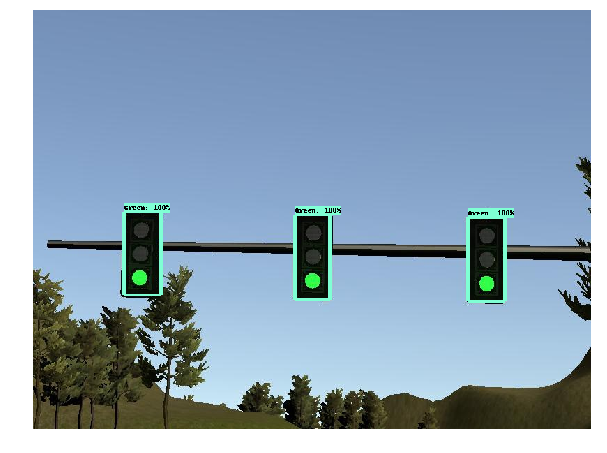

In [6]:
draw(samples_sim[0])

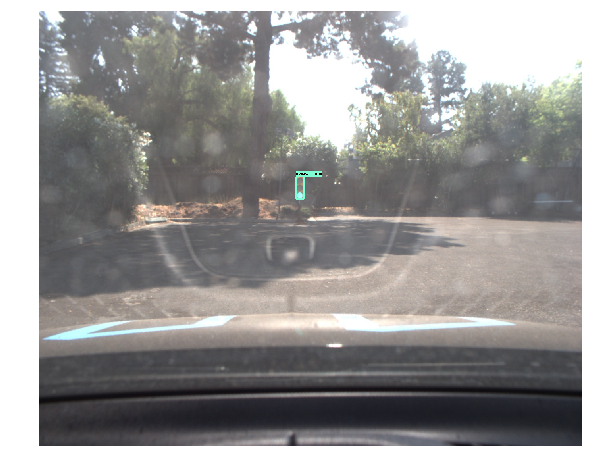

In [7]:
draw(samples_real[0])

## Evaluate models
We have implemented the traffic light detection in `light_classification.tl_classifier.TLClassifier`, let's us this to evaluate our trained model


In [8]:
SUPPORTED_MODELS = [
    'faster_rcnn_resnet101_coco',
    'ssd_inception_v2_coco',
    'ssd_mobilenet_v1_coco'
]

DATA_CONFIG = {
    'real' : {'image_h' : 1096, 
              'image_w' : 1368, 
              'samples' : samples_real
             },
    'sim'  : {'image_h' : 600, 
              'image_w' : 800,  
              'samples' : samples_sim
             }
}

In [9]:
def get_sample_class(sample):
    if len(sample['annotations']) == 0:
        return 4
    classes = set()
    for annotation in sample['annotations']:
        classes.add(LABEL_MAP[annotation['class']])
    
    if len(classes) > 1: # we ignore sample that has multiple detection
        return None
    
    return list(classes)[0]

def import_model(model_name, data_type):
    if model_name not in SUPPORTED_MODELS:
        raise Exception('Model {} is not supported'.format(model_name))
    if data_type not in DATA_CONFIG:
        raise Exception('Data type {} is not supported'.format(data_type))
        
    model_path = '../frozen_{}/{}/frozen_inference_graph.pb'.format(data_type, model_name)
    image_h = DATA_CONFIG[data_type]['image_h']
    image_w = DATA_CONFIG[data_type]['image_w']    
    
    return TLClassifier(model_path=model_path, 
                        img_height=image_h,
                        img_width=image_w)

def evaluate_model(model, samples, verbose=True):
    nb_samples = 0
    nb_correct = 0
    wrong_idx = []
    running_time = []
    for i,sample in enumerate(samples):
        truth = get_sample_class(sample)
        if truth is None:
            continue
        
        nb_samples += 1
        img = load_img_as_ndarray(sample['filename'])
        time_start = time.time()
        prediction = model.get_classification(img)
        elapsed = (time.time() - time_start)*1000
        running_time.append(elapsed)
        
        if (prediction != truth):
            wrong_idx.append(i)
        else:
            nb_correct += 1
        
        if verbose:
            sys.stdout.write('\rDone sample {:>3d}-th in {:.2f} ms'.format(i+1, elapsed))
            if (nb_samples % 20 == 0):
                print('')
    
    accuracy = 1.0*nb_correct/nb_samples

    return accuracy, wrong_idx, running_time

def visualize_model(model, sample, figsize=(10,8)):
    img = load_img_as_ndarray(sample['filename'])
    
    boxes, classes, scores = model.get_detections(img)
    idx = np.where(scores > 0.5)[0]
    img_bb = vis_util.visualize_boxes_and_labels_on_image_array(
        img,
        boxes[idx],
        classes[idx],
        scores[idx],
        CATEGORY_INDEX,
        use_normalized_coordinates=True,
        line_thickness=6
    )

    fig = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img_bb)    

def analyse_runtime(running_time):
    min_runtime = np.min(running_time)
    max_runtime = np.max(running_time)
    mean_runtime = np.mean(running_time)
    print('Running Time Summary\n-------------------------------')
    print('Min/Max {:.2f}/{:.2f} (ms)\nMean {:.2f} (ms)'.format(min_runtime, max_runtime, mean_runtime))

### Evaluate for sim dataset
We evaluate our models on sim dataset

In [10]:
samples = samples_sim

* *ssd_mobilenet_v1_coco*

In [11]:
ssd_mobilenet_v1_coco_sim = import_model('ssd_mobilenet_v1_coco', 'sim')

In [12]:
accuracy, wrong_idx, running_time = evaluate_model(ssd_mobilenet_v1_coco_sim, samples, verbose=False)

print('In sim, ssd_mobilenet_v1_coco predicts correctly {:.2f}%s'.format(100*accuracy))
analyse_runtime(running_time)

In sim, ssd_mobilenet_v1_coco predicts correctly 97.47%s
Running Time Summary
-------------------------------
Min/Max 9.87/24.64 (ms)
Mean 12.43 (ms)


* ssd_inception_v2_coco

In [13]:
ssd_inception_v2_coco_sim = import_model('ssd_inception_v2_coco', 'sim')

In [14]:
accuracy, wrong_idx, running_time = evaluate_model(ssd_inception_v2_coco_sim, samples, verbose=False)

print('In sim, ssd_inception_v2_coco predicts correctly {:.2f}%s'.format(100*accuracy))
analyse_runtime(running_time)

In sim, ssd_inception_v2_coco predicts correctly 97.11%s
Running Time Summary
-------------------------------
Min/Max 13.99/29.31 (ms)
Mean 16.33 (ms)


In [15]:
faster_rcnn_resnet101_coco_sim = import_model('faster_rcnn_resnet101_coco', 'sim')

In [16]:
accuracy, wrong_idx, running_time = evaluate_model(faster_rcnn_resnet101_coco_sim, samples, verbose=False)

print('In sim, faster_rcnn_resnet101_coco predicts correctly {:.2f}%s'.format(100*accuracy))
analyse_runtime(running_time)

In sim, faster_rcnn_resnet101_coco predicts correctly 98.92%s
Running Time Summary
-------------------------------
Min/Max 51.35/69.64 (ms)
Mean 55.82 (ms)


### Evaluate for real dataset
Next, we evaluate our models in real dataset

In [17]:
samples = samples_real
ssd_mobilenet_v1_coco_real = import_model('ssd_mobilenet_v1_coco', 'real')
ssd_inception_v2_coco_real = import_model('ssd_inception_v2_coco', 'real')
faster_rcnn_resnet101_coco_real = import_model('faster_rcnn_resnet101_coco', 'real')

In [18]:
accuracy, wrong_idx, running_time = evaluate_model(ssd_mobilenet_v1_coco_real, samples, verbose=False)

print('In real, ssd_mobilenet_v1_coco predicts correctly {:.2f}%s'.format(100*accuracy))
analyse_runtime(running_time)

In real, ssd_mobilenet_v1_coco predicts correctly 98.11%s
Running Time Summary
-------------------------------
Min/Max 10.50/20.32 (ms)
Mean 13.00 (ms)


In [19]:
accuracy, wrong_idx, running_time = evaluate_model(ssd_inception_v2_coco_real, samples, verbose=False)

print('In real, ssd_inception_v2_coco predicts correctly {:.2f}%s'.format(100*accuracy))
analyse_runtime(running_time)

In real, ssd_inception_v2_coco predicts correctly 96.86%s
Running Time Summary
-------------------------------
Min/Max 14.59/30.16 (ms)
Mean 17.29 (ms)


In [20]:
accuracy, wrong_idx, running_time = evaluate_model(faster_rcnn_resnet101_coco_real, samples, verbose=False)

print('In real, faster_rcnn_resnet101_coco predicts correctly {:.2f}%s'.format(100*accuracy))
analyse_runtime(running_time)

In real, faster_rcnn_resnet101_coco predicts correctly 100.00%s
Running Time Summary
-------------------------------
Min/Max 108.01/124.17 (ms)
Mean 114.35 (ms)


## Summary of Metric
### Using Tensorflow 1.3.0 and CPU only
So we have the following result for sim (runtime is in ms)

|  metric    | ssd_mobilenet_v1_coco | ssd_inception_v2_coco | faster_rcnn_resnet101_coco |
| ---: | :---: | :---: | :---: |
| accuracy | 97.47% | 97.11%  | 98.92% |
| min runtime | 64  | 100     | 1554 |
| max runtime | 90  | 149     | 1932 |
| mean runtime | 69 | 110     | 1598 |

And for real dataset

|  metric    | ssd_mobilenet_v1_coco | ssd_inception_v2_coco | faster_rcnn_resnet101_coco |
| ---: | :---: | :---: | :---: |
| accuracy | 98.11% | 96.86%  | 100% |
| min runtime | 71  | 107     | 4566 |
| max runtime | 93  | 135     | 5200 |
| mean runtime | 82 | 118     | 4660 |

### Using Tensorflow 1.8.0 and GPU
We obtain the following result for sim

|  metric    | ssd_mobilenet_v1_coco | ssd_inception_v2_coco | faster_rcnn_resnet101_coco |
| ---: | :---: | :---: | :---: |
| accuracy | 97.47% | 97.11%  | 98.92% |
| min runtime | 10  | 14     | 51 |
| max runtime | 25  | 29     | 70 |
| mean runtime | 12 | 16     | 56 |

And for real dataset

|  metric    | ssd_mobilenet_v1_coco | ssd_inception_v2_coco | faster_rcnn_resnet101_coco |
| ---: | :---: | :---: | :---: |
| accuracy | 98.11% | 96.86%  | 100% |
| min runtime | 11  | 15     | 108 |
| max runtime | 20  | 30     | 124 |
| mean runtime | 13 | 17     | 114 |
